In [1]:
import capnp
import codecs
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import statistics

capnp.remove_import_hook()
interface_capnp = capnp.load("../../../cpp-tool/capnproto/interface.capnp", imports=["/usr/local/include"])

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /root/.vscode-server/bin/7f329fe6c66b0f86ae1574c2911b681ad5a45d63


In [2]:
client = capnp.TwoPartyClient("cpp-tool:21654")
processDataUpdates = client.bootstrap().cast_as(interface_capnp.ProcessDataUpdates)

# Generate event log

In [3]:
!capnp convert json:binary ../../../cpp-tool/capnproto/interface.capnp RuleModel < ../data-generation/dataGenerationModel.json > /tmp/dataGenerationModel.bin
with open("/tmp/dataGenerationModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(model).wait().string)

IF light1 = red THEN light2 IN {red}
IF light2 = green THEN cost IN [0.000000, 10.000000]
IF light2 = yellow THEN DELTA cost IN [12.000000, 15.000000]
IF light1 = green THEN agility = 42.000000
IF light1: red -> yellow THEN agility = agility_prev * 0.900000
IF light2: yellow -> red THEN cost = cost_prev - 7.000000



In [4]:
eventLogPromise = processDataUpdates.generateEventLog(model=model, numberOfTraces=100, traceLength=20)
resolvedEventLogPromise = eventLogPromise.wait()

In [5]:
updateRules = [x.rule.updateRule for x in resolvedEventLogPromise.ruleUsage]
frequencies = [x.frequency for x in resolvedEventLogPromise.ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "cost",\n  differenceRule = (cons...        239
1  ( variable = "light2",\n  valueSetRule = (set ...        642
2  ( variable = "agility",\n  factorRule = (const...        198
3  ( variable = "cost",\n  changeRangeRule = (min...        453
4  ( variable = "agility",\n  valueRule = (consta...        673
5  ( variable = "cost",\n  valueRangeRule = (min ...        434

# Looking at distributions

In [6]:
from visualdistribution import visualizeVariableDistribution
from visualdistribution import collectEntries

Mode of the distribution: 42.0


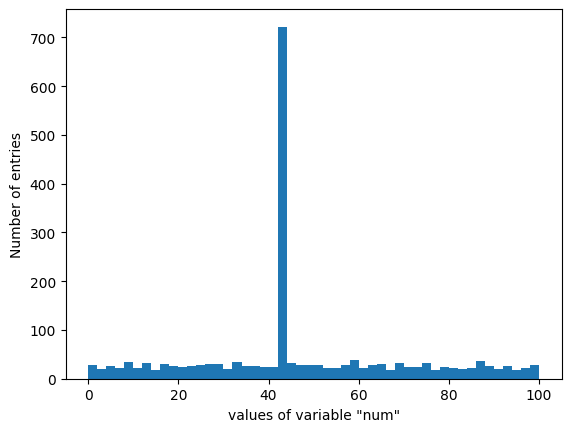

In [7]:
visualizeVariableDistribution(resolvedEventLogPromise.log, "num")
plt.show()

The value rule for 42 is clearly visible and also the mode of the distribution.

Mode of the distribution: 8.3


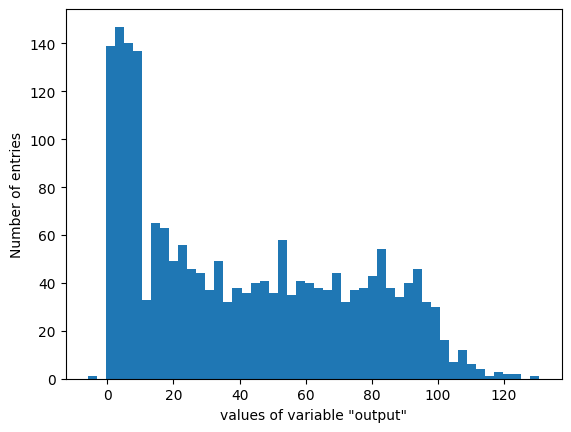

In [8]:
visualizeVariableDistribution(resolvedEventLogPromise.log, "output")
plt.show()

The range rule in the interval [0,10] is clearly visible and the mode lies in this interval.

Mode of the distribution: 0.0


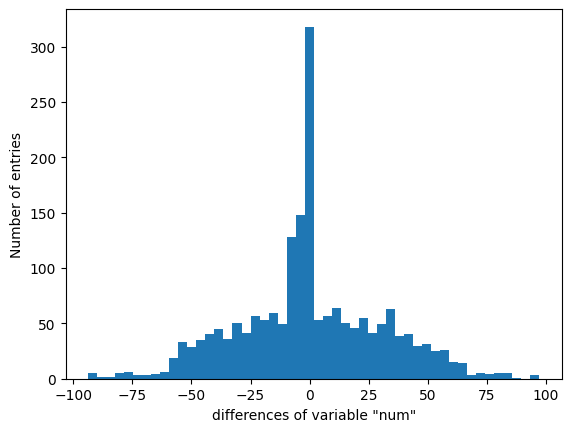

In [9]:
visualizeVariableDistribution(resolvedEventLogPromise.log, "num", "difference")
plt.show()

Despite any rule on the differences of "num", there is a peak around 0. This is probably due to repeatedly setting the value 42.

Mode of the distribution: -7.0


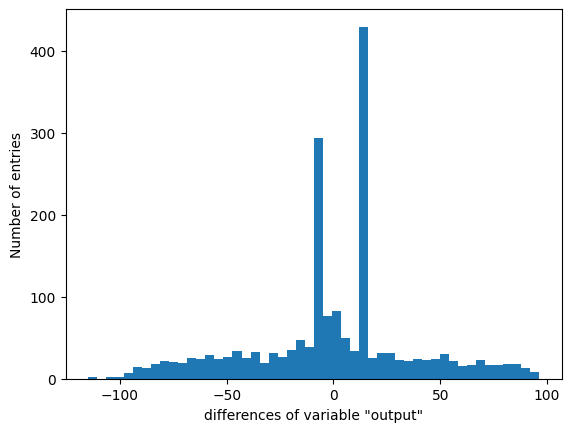

In [10]:
visualizeVariableDistribution(resolvedEventLogPromise.log, "output", "difference")
plt.show()

The mode and the second highest peak show the effects of the difference rule with constant -7. The higher peak at around 10 is caused by the change range rule with the interval [12,15].

Mode of the distribution: 1.0


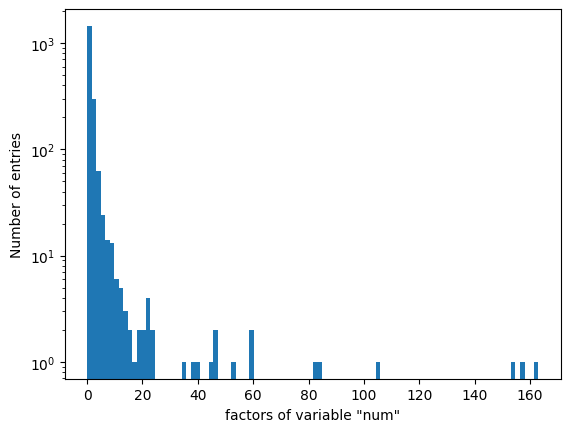

In [11]:
visualizeVariableDistribution(resolvedEventLogPromise.log, "num", "factor", bins=100)
plt.yscale("log")
plt.show()

Neither the mode nor the histogram show the factor rule with constant 0.9. Similar to how difference distributions tend to have a trivial mode around 0, the factor distribution has a trivial mode at 1 when idendentical values are set subsequently.

Mode of the distribution: 2.0


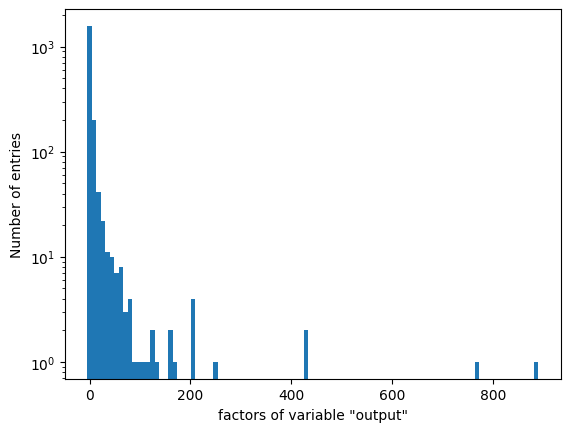

In [12]:
visualizeVariableDistribution(resolvedEventLogPromise.log, "output", "factor", bins=100)
plt.yscale("log")
plt.show()

Without any rules on the factor of "output", the distribution's mode is 4. As of now, I can't explain why.

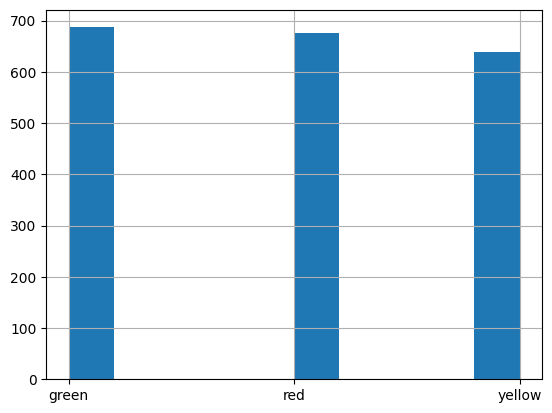

In [13]:
light1Entries = collectEntries(resolvedEventLogPromise.log, "light1")
pd.Series(light1Entries).hist()
plt.show()

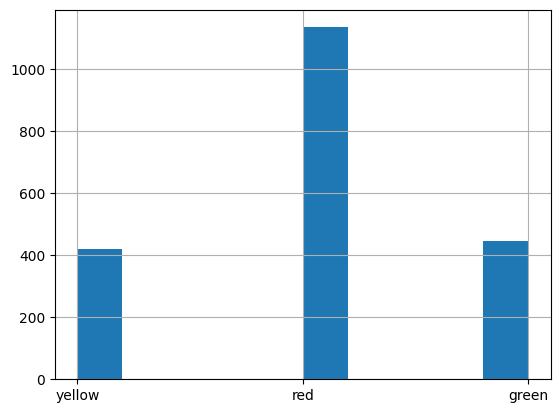

In [14]:
light2Entries = collectEntries(resolvedEventLogPromise.log, "light2")
pd.Series(light2Entries).hist()
plt.show()

# Adding wrong rules to the model

In [16]:
nullModel = interface_capnp.RuleModel.new_message(rules=[])

scorePromise = processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=nullModel)
score = scorePromise.wait().result
score

41008.3326276768

In [17]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < wrongFactorRuleModel.json > /tmp/wrongFactorRuleModel.bin
with open("/tmp/wrongFactorRuleModel.bin", "rb") as file:
    wrongFactorRuleModel = interface_capnp.RuleModel.read(file)

scorePromise = processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=wrongFactorRuleModel)
score = scorePromise.wait().result
score

40914.44854609922

In [18]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < wrongValueSetRuleModel.json > /tmp/wrongValueSetRuleModel.bin
with open("/tmp/wrongValueSetRuleModel.bin", "rb") as file:
    wrongValueSetRuleModel = interface_capnp.RuleModel.read(file)

scorePromise = processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=wrongValueSetRuleModel)
score = scorePromise.wait().result
score

40801.99512839544

In [19]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < impreciseRuleModel.json > /tmp/impreciseRuleModel.bin
with open("/tmp/impreciseRuleModel.bin", "rb") as file:
    impreciseRuleModel = interface_capnp.RuleModel.read(file)

scorePromise = processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=impreciseRuleModel)
score = scorePromise.wait().result
score

39961.89778960517

In [20]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < tooPreciseRuleModel.json > /tmp/tooPreciseRuleModel.bin
with open("/tmp/tooPreciseRuleModel.bin", "rb") as file:
    tooPreciseRuleModel = interface_capnp.RuleModel.read(file)

scorePromise = processDataUpdates.calculateMdlScore(log=resolvedEventLogPromise.log, model=tooPreciseRuleModel)
score = scorePromise.wait().result
score

40395.03349460487

Rules that are wrong/off still save bits. Could be a trap for greedy search.

# Trying a simple search

## Data generated from complex model

In [6]:
modelPromise = processDataUpdates.findModel(resolvedEventLogPromise.log)
modelPromise.wait()

<interface.capnp:ProcessDataUpdates.findModel$Results reader (model = (rules = [(condition = (elements = [(atomicCondition = (variable = "light1", categoricalValueCondition = (value = "red")))]), updateRule = (variable = "light2", valueSetRule = (set = ["red"]))), (condition = (elements = [(atomicCondition = (variable = "light1", categoricalTransitionCondition = (before = "red", after = "yellow")))]), updateRule = (variable = "num", factorRule = (constant = 0.9))), (condition = (elements = [(atomicCondition = (variable = "light2", categoricalTransitionCondition = (before = "yellow", after = "red")))]), updateRule = (variable = "output", differenceRule = (constant = -7)))], variables = [(name = "output", numerical = void), (name = "num", numerical = void), (name = "light2", categorical = (domain = ["green", "red", "yellow"])), (name = "light1", categorical = (domain = ["green", "red", "yellow"]))]))>

Most rules that predict single values are found. Range rules are not found.

### Debug output

```text
Current variable: light1
Baseline score: 41008.3
Best rules:
Score: 41024
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalTransitionCondition = (before = "green", after = "red")))]), updateRule = (variable = "light1", valueSetRule = (set = ["red"])))
Score: 41031.1
Rule: (condition = (elements = [(atomicCondition = (variable = "output", numericalValueCondition = (value = 0)))]), updateRule = (variable = "light1", valueSetRule = (set = ["red"])))
Score: 41031.4
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalValueCondition = (value = "green")))]), updateRule = (variable = "light1", valueSetRule = (set = ["red"])))
Score: 41031.5
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalValueCondition = (value = "yellow")))]), updateRule = (variable = "light1", valueSetRule = (set = ["red"])))
Score: 41031.8
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalTransitionCondition = (before = "green", after = "yellow")))]), updateRule = (variable = "light1", valueSetRule = (set = ["red"])))
```
Since light1 is generated completely random, even the best rule does not produce any compression gain.

```text
Current variable: light2
Baseline score: 41008.3
Best rules:
Score: 40457.7
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalValueCondition = (value = "red")))]), updateRule = (variable = "light2", valueSetRule = (set = ["red"])))
Score: 40847
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalTransitionCondition = (before = "red", after = "red")))]), updateRule = (variable = "light2", valueSetRule = (set = ["red"])))
Score: 40851.2
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalTransitionCondition = (before = "green", after = "red")))]), updateRule = (variable = "light2", valueSetRule = (set = ["red"])))
Score: 40853.8
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalTransitionCondition = (before = "yellow", after = "red")))]), updateRule = (variable = "light2", valueSetRule = (set = ["red"])))
Score: 41031.8
Rule: (condition = (elements = [(atomicCondition = (variable = "output", upperBoundCondition = (value = 0)))]), updateRule = (variable = "light2", valueSetRule = (set = ["red"])))
```
The best rule for light2 is the one that was used in generation. Subsequently good rules are essentially the same but with an overly specific condition.

```text
Current variable: num
Baseline score: 40457.7
Best rules:
Score: 38403.5
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalTransitionCondition = (before = "red", after = "yellow")))]), updateRule = (variable = "num", factorRule = (constant = 0.9)))
Score: 39465.8
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalValueCondition = (value = "green")))]), updateRule = (variable = "num", valueRule = (constant = 42)))
Score: 39749.8
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalTransitionCondition = (before = "red", after = "yellow")))]), updateRule = (variable = "num", differenceRule = (constant = -2.6999999999999993)))
Score: 40159.4
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalTransitionCondition = (before = "green", after = "green")))]), updateRule = (variable = "num", differenceRule = (constant = 0)))
Score: 40159.7
Rule: (condition = (elements = [(atomicCondition = (variable = "light1", categoricalTransitionCondition = (before = "red", after = "green")))]), updateRule = (variable = "num", valueRule = (constant = 42)))
```
The true generating rules for num are the two rules that compress best. The second one (with value 42) is only missed since the search finds one rule per target variable. Subsequently good rules are again overly specific variants of the true rules.

```text
Current variable: output
Baseline score: 38403.5
Best rules:
Score: 25496.6
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalTransitionCondition = (before = "yellow", after = "red")))]), updateRule = (variable = "output", differenceRule = (constant = -7)))
Score: 36006.4
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalValueCondition = (value = "yellow")))]), updateRule = (variable = "output", differenceRule = (constant = 13.5)))
Score: 37041.2
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalTransitionCondition = (before = "red", after = "yellow")))]), updateRule = (variable = "output", differenceRule = (constant = 13.5)))
Score: 37246.4
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalTransitionCondition = (before = "red", after = "yellow")))]), updateRule = (variable = "output", changeRangeRule = (min = 11.999999999999993, max = 17.400000000000006)))
Score: 37563.1
Rule: (condition = (elements = [(atomicCondition = (variable = "light2", categoricalTransitionCondition = (before = "yellow", after = "red")))]), updateRule = (variable = "output", factorRule = (constant = 0.92914979757085026)))
```
The top 2 rules for output are essentially the two generating rules. However, the second rule predicts a single value instead of the interval that was used to generate the data. The first interval rule only appears at the 4th position with an overly specific condition. It seems that interval rules have a (systematic?) disadvantage in the MDL score.

## Data generated from empty model

In [7]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < dataGenerationModelEmpty.json > /tmp/dataGenerationModelEmpty.bin
with open("/tmp/dataGenerationModelEmpty.bin", "rb") as file:
    emptyModel = interface_capnp.RuleModel.read(file)
emptyModel

<interface.capnp:RuleModel reader (rules = [], variables = [(name = "light1", categorical = (domain = ["red", "yellow", "green"])), (name = "light2", categorical = (domain = ["red", "yellow", "green"])), (name = "num", numerical = void), (name = "output", numerical = void)])>

In [8]:
logFromEmptyPromise = processDataUpdates.generateEventLog(model=emptyModel, numberOfTraces=100, traceLength=20)
modelPromise = processDataUpdates.findModel(logFromEmptyPromise.wait().log)
modelPromise.wait()

<interface.capnp:ProcessDataUpdates.findModel$Results reader (model = (rules = [], variables = []))>

Data from an empty model leads to an empty model that is found by the search!

# Search that can find multiple update rules per variable (and fixed interval generation)

## Data generated from complex model

In [6]:
modelPromise = processDataUpdates.findModel(resolvedEventLogPromise.log)
foundModel = modelPromise.wait().model
print(processDataUpdates.modelToString(foundModel).wait().string)

IF light1 = green THEN agility = 42.000000
IF light2 = yellow THEN DELTA cost IN [12.000000, 15.000000]
IF light1 = red THEN light2 IN {red}
IF light1: red -> yellow THEN agility = agility_prev * 0.900474
IF light2: yellow -> red THEN cost = cost_prev - 7.000000
IF NOT (light1 = green) THEN agility IN [0.000000, 100.000000]
IF light2 = green THEN cost IN [0.000000, 10.000000]
IF light2: red -> red THEN cost IN [0.300000, 100.000000]



The first rules found are essentially the ones that were used to generate the data. Unfortunately, spurious range rules are found in addition which just show the global range of the data. Still, these range rules make sense since they cover samples that the other rules do not cover and it correctly explains the background noise used. Also the factor rule with 0.9 is not found which is caused by the first rule being found in reverse. This leads to the correct factor rule causing a disallowed cycle in the model.

## Data generated from empty model

In [7]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < dataGenerationModelEmpty.json > /tmp/dataGenerationModelEmpty.bin
with open("/tmp/dataGenerationModelEmpty.bin", "rb") as file:
    emptyModel = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(emptyModel).wait().string)

<empty model>


In [8]:
logFromEmptyPromise = processDataUpdates.generateEventLog(model=emptyModel, numberOfTraces=100, traceLength=20)
modelPromise = processDataUpdates.findModel(logFromEmptyPromise.wait().log)
foundModel = modelPromise.wait().model
print(processDataUpdates.modelToString(foundModel).wait().string)

<empty model>


Still, no rule is found in completely random data. :)

# Search in realistically sized event log

In [3]:
!capnp convert json:binary ../cpp-tool/capnproto/interface.capnp RuleModel < dataGenerationModel.json > /tmp/dataGenerationModel.bin
with open("/tmp/dataGenerationModel.bin", "rb") as file:
    model = interface_capnp.RuleModel.read(file)
print(processDataUpdates.modelToString(model).wait().string)

IF light1 = red THEN light2 IN {red}
IF light2 = green THEN output IN [0.000000, 10.000000]
IF light2 = yellow THEN DELTA output IN [12.000000, 15.000000]
IF light1 = green THEN num = 42.000000
IF light1: red -> yellow THEN num = num_prev * 0.900000
IF light2: yellow -> red THEN output = output_prev - 7.000000



In [4]:
eventLogPromise = processDataUpdates.generateEventLog(model=model, numberOfTraces=100000, traceLength=5)
resolvedEventLogPromise = eventLogPromise.wait()

In [5]:
updateRules = [x.rule.updateRule for x in resolvedEventLogPromise.ruleUsage]
frequencies = [x.frequency for x in resolvedEventLogPromise.ruleUsage]
pd.DataFrame({"updateRule": updateRules, "frequency": frequencies})

updateRule  frequency
0  ( variable = "num",\n  factorRule = (constant ...      44310
1  ( variable = "output",\n  valueRangeRule = (mi...     110499
2  ( variable = "output",\n  differenceRule = (co...      49538
3  ( variable = "light2",\n  valueSetRule = (set ...     166709
4  ( variable = "output",\n  changeRangeRule = (m...      89366
5  ( variable = "num",\n  valueRule = (constant =...     166475

In [6]:
modelPromise = processDataUpdates.findModel(resolvedEventLogPromise.log)
foundModel = modelPromise.wait().model
print(processDataUpdates.modelToString(foundModel).wait().string)

IF light1 = red THEN light2 IN {red}
IF light1: red -> yellow THEN num = num_prev * 0.900000
IF light2: yellow -> red THEN output = output_prev - 7.000000
IF light1 = green THEN num = 42.000000
IF light2 = yellow THEN DELTA output IN [12.000000, 15.000000]
IF light1 = red THEN num IN [0.000000, 100.000000]
IF light2 = green THEN output IN [0.000000, 10.000000]
IF light1 = yellow THEN num IN [0.000000, 100.000000]
IF light2: red -> red THEN output IN [0.000000, 100.000000]
IF light2: green -> red THEN output IN [0.000000, 100.000000]



Finished within ~10 hours with reasonable results. Even more rules are found that describe the background noise, probably due to the large dataset where the few bits that can be saved many times outplay the cost of the rule in the model.

### Debug output

```text
Generating modification rules took 18.9246 sec
Current variable: light1
Baseline score: 1.02339e+07
Searching 412 modification rules...
Scoring modification rules took 174.505 sec
Best rules:
Score: 1.0234e+07
Rule: IF num = 42.800000 THEN light1 IN {yellow}
Score: 1.0234e+07
Rule: IF num = 20.300000 THEN light1 IN {yellow}
Score: 1.0234e+07
Rule: IF num = 84.200000 THEN light1 IN {yellow}
Score: 1.0234e+07
Rule: IF num = 28.400000 THEN light1 IN {yellow}
Score: 1.0234e+07
Rule: IF num = 3.200000 THEN light1 IN {yellow}
Generating modification rules took 20.6043 sec
Current variable: light2
Baseline score: 1.02339e+07
Searching 412 modification rules...
Scoring modification rules took 170.192 sec
Best rules:
Score: 1.00926e+07
Rule: IF light1 = red THEN light2 IN {red}
Score: 1.01961e+07
Rule: IF light1: green -> red THEN light2 IN {red}
Score: 1.01962e+07
Rule: IF light1: red -> red THEN light2 IN {red}
Score: 1.01965e+07
Rule: IF light1: yellow -> red THEN light2 IN {red}
Score: 1.02339e+07
Rule: IF output: 17.000000 -> 10.000000 THEN light2 IN {red}
Generating modification rules took 257.062 sec
Current variable: num
Baseline score: 1.00926e+07
Searching 1115 modification rules...
Scoring modification rules took 736.259 sec
Best rules:
Score: 9.62653e+06
Rule: IF light1: red -> yellow THEN num = num_prev * 0.900000
Score: 9.82903e+06
Rule: IF light1 = green THEN num = 42.000000
Score: 9.88816e+06
Rule: IF light1 = yellow THEN num = num_prev * 0.900000
Score: 9.92156e+06
Rule: IF light1: red -> yellow THEN DELTA num IN [-10.000000, 0.000000]
Score: 9.99665e+06
Rule: IF light1 = red THEN num IN [0.000000, 100.000000]
Generating modification rules took 349.408 sec
Current variable: output
Baseline score: 9.62653e+06
Searching 1119 modification rules...
Scoring modification rules took 1417.24 sec
Best rules:
Score: 9.11454e+06
Rule: IF light2: yellow -> red THEN output = output_prev - 7.000000
Score: 9.12355e+06
Rule: IF light2 = yellow THEN DELTA output IN [12.000000, 15.000000]
Score: 9.34359e+06
Rule: IF light2: red -> yellow THEN DELTA output IN [12.000000, 15.000000]
Score: 9.42496e+06
Rule: IF light2 = green THEN output IN [0.000000, 10.000000]
Score: 9.50293e+06
Rule: IF light2: yellow -> yellow THEN DELTA output IN [12.000000, 15.000000]
Generating modification rules took 0.00015 sec
Current variable: light1
Baseline score: 9.11454e+06
Searching 0 modification rules...
Scoring modification rules took 4e-06 sec
Best rules:
Generating modification rules took 9.1184 sec
Current variable: light2
Baseline score: 9.11454e+06
Searching 212 modification rules...
Scoring modification rules took 281.708 sec
Best rules:
Score: 9.11506e+06
Rule: IF num: 42.000000 -> 46.300000 THEN light2 IN {red}
Score: 9.11513e+06
Rule: IF num: 42.000000 -> 38.700000 THEN light2 IN {red}
Score: 9.11516e+06
Rule: IF num: 42.000000 -> 16.200000 THEN light2 IN {red}
Score: 9.11517e+06
Rule: IF num: 42.000000 -> 3.000000 THEN light2 IN {red}
Score: 9.11522e+06
Rule: IF num: 42.000000 -> 68.600000 THEN light2 IN {red}
Generating modification rules took 250.63 sec
Current variable: num
Baseline score: 9.11454e+06
Searching 1115 modification rules...
Scoring modification rules took 1474.36 sec
Best rules:
Score: 8.85096e+06
Rule: IF light1 = green THEN num = 42.000000
Score: 9.01858e+06
Rule: IF light1 = red THEN num IN [0.000000, 100.000000]
Score: 9.04407e+06
Rule: IF light1: yellow -> green THEN num = 42.000000
Score: 9.04416e+06
Rule: IF light1: red -> green THEN num = 42.000000
Score: 9.04468e+06
Rule: IF light1: green -> green THEN num = num_prev + 0.000000
Generating modification rules took 357.687 sec
Current variable: output
Baseline score: 8.85096e+06
Searching 1119 modification rules...
Scoring modification rules took 1968.11 sec
Best rules:
Score: 8.34798e+06
Rule: IF light2 = yellow THEN DELTA output IN [12.000000, 15.000000]
Score: 8.56802e+06
Rule: IF light2: red -> yellow THEN DELTA output IN [12.000000, 15.000000]
Score: 8.64939e+06
Rule: IF light2 = green THEN output IN [0.000000, 10.000000]
Score: 8.72736e+06
Rule: IF light2: yellow -> yellow THEN DELTA output IN [12.000000, 15.000000]
Score: 8.75472e+06
Rule: IF light2: green -> yellow THEN DELTA output IN [12.000000, 15.000000]
Generating modification rules took 0.000336 sec
Current variable: light1
Baseline score: 8.34798e+06
Searching 0 modification rules...
Scoring modification rules took 0.000279 sec
Best rules:
Generating modification rules took 9.14353 sec
Current variable: light2
Baseline score: 8.34798e+06
Searching 212 modification rules...
Scoring modification rules took 391.087 sec
Best rules:
Score: 8.34853e+06
Rule: IF num: 42.000000 -> 46.300000 THEN light2 IN {red}
Score: 8.3486e+06
Rule: IF num: 42.000000 -> 38.700000 THEN light2 IN {red}
Score: 8.34864e+06
Rule: IF num: 42.000000 -> 16.200000 THEN light2 IN {red}
Score: 8.34864e+06
Rule: IF num: 42.000000 -> 3.000000 THEN light2 IN {red}
Score: 8.3487e+06
Rule: IF num: 42.000000 -> 68.600000 THEN light2 IN {red}
Generating modification rules took 252.359 sec
Current variable: num
Baseline score: 8.34798e+06
Searching 1115 modification rules...
Scoring modification rules took 2038.82 sec
Best rules:
Score: 8.25202e+06
Rule: IF light1 = red THEN num IN [0.000000, 100.000000]
Score: 8.29838e+06
Rule: IF light2 = red THEN num IN [0.000000, 100.000000]
Score: 8.32183e+06
Rule: IF light1 = yellow THEN num IN [0.000000, 100.000000]
Score: 8.32222e+06
Rule: IF light1: yellow -> yellow THEN num IN [0.000000, 100.000000]
Score: 8.32236e+06
Rule: IF light1: green -> red THEN num IN [0.000000, 100.000000]
Generating modification rules took 344.868 sec
Current variable: output
Baseline score: 8.25202e+06
Searching 1119 modification rules...
Scoring modification rules took 2505.01 sec
Best rules:
Score: 8.05045e+06
Rule: IF light2 = green THEN output IN [0.000000, 10.000000]
Score: 8.1622e+06
Rule: IF light2: red -> green THEN output IN [0.000000, 10.000000]
Score: 8.21603e+06
Rule: IF light2: yellow -> green THEN output IN [0.000000, 10.000000]
Score: 8.21629e+06
Rule: IF light2: green -> green THEN output IN [0.000000, 10.000000]
Score: 8.2265e+06
Rule: IF light2: red -> red THEN output IN [0.000000, 100.000000]
Generating modification rules took 0.000671 sec
Current variable: light1
Baseline score: 8.05045e+06
Searching 0 modification rules...
Scoring modification rules took 1.9e-05 sec
Best rules:
Generating modification rules took 9.10217 sec
Current variable: light2
Baseline score: 8.05045e+06
Searching 212 modification rules...
Scoring modification rules took 517.546 sec
Best rules:
Score: 8.05102e+06
Rule: IF num: 42.000000 -> 46.300000 THEN light2 IN {red}
Score: 8.05109e+06
Rule: IF num: 42.000000 -> 38.700000 THEN light2 IN {red}
Score: 8.05113e+06
Rule: IF num: 42.000000 -> 16.200000 THEN light2 IN {red}
Score: 8.05114e+06
Rule: IF num: 42.000000 -> 3.000000 THEN light2 IN {red}
Score: 8.0512e+06
Rule: IF num: 42.000000 -> 68.600000 THEN light2 IN {red}
Generating modification rules took 251.332 sec
Current variable: num
Baseline score: 8.05045e+06
Searching 1115 modification rules...
Scoring modification rules took 2600.51 sec
Best rules:
Score: 8.0243e+06
Rule: IF light1 = yellow THEN num IN [0.000000, 100.000000]
Score: 8.02469e+06
Rule: IF light1: yellow -> yellow THEN num IN [0.000000, 100.000000]
Score: 8.025e+06
Rule: IF light1: green -> yellow THEN num IN [0.000000, 100.000000]
Score: 8.02504e+06
Rule: IF light1: green -> yellow THEN DELTA num IN [-42.000000, 58.000000]
Score: 8.05067e+06
Rule: IF output: 21.000000 -> 14.000000 THEN num IN [0.000000, 97.800000]
Generating modification rules took 344.568 sec
Current variable: output
Baseline score: 8.0243e+06
Searching 1119 modification rules...
Scoring modification rules took 3063.18 sec
Best rules:
Score: 7.99878e+06
Rule: IF light2: red -> red THEN output IN [0.000000, 100.000000]
Score: 8.01433e+06
Rule: IF light2: green -> red THEN output IN [0.000000, 100.000000]
Score: 8.01503e+06
Rule: IF light1: red -> red THEN output IN [0.000000, 100.000000]
Score: 8.0209e+06
Rule: IF light2: green -> red THEN DELTA output IN [-9.900000, 99.800000]
Score: 8.02451e+06
Rule: IF num: 42.000000 -> 68.600000 THEN output IN [0.000000, 107.100000]
Generating modification rules took 0.00026 sec
Current variable: light1
Baseline score: 7.99878e+06
Searching 0 modification rules...
Scoring modification rules took 8e-06 sec
Best rules:
Generating modification rules took 9.17451 sec
Current variable: light2
Baseline score: 7.99878e+06
Searching 212 modification rules...
Scoring modification rules took 631.18 sec
Best rules:
Score: 7.99936e+06
Rule: IF num: 42.000000 -> 46.300000 THEN light2 IN {red}
Score: 7.99944e+06
Rule: IF num: 42.000000 -> 38.700000 THEN light2 IN {red}
Score: 7.99948e+06
Rule: IF num: 42.000000 -> 16.200000 THEN light2 IN {red}
Score: 7.99948e+06
Rule: IF num: 42.000000 -> 3.000000 THEN light2 IN {red}
Score: 7.99955e+06
Rule: IF num: 42.000000 -> 68.600000 THEN light2 IN {red}
Generating modification rules took 247.515 sec
Current variable: num
Baseline score: 7.99878e+06
Searching 1115 modification rules...
Scoring modification rules took 3270.8 sec
Best rules:
Score: 7.99898e+06
Rule: IF output: 16.700000 -> 9.700000 THEN num = num_prev + 0.000000
Score: 7.99899e+06
Rule: IF output: 19.200000 -> 12.200000 THEN num = num_prev + 0.000000
Score: 7.99899e+06
Rule: IF output: 16.000000 -> 9.000000 THEN num = num_prev + 0.000000
Score: 7.99899e+06
Rule: IF output: 22.400000 -> 15.400000 THEN num = num_prev + 0.000000
Score: 7.999e+06
Rule: IF output: 20.300000 -> 13.300000 THEN num = num_prev + 0.000000
Generating modification rules took 348.428 sec
Current variable: output
Baseline score: 7.99878e+06
Searching 1119 modification rules...
Scoring modification rules took 3276.63 sec
Best rules:
Score: 7.9888e+06
Rule: IF light2: green -> red THEN output IN [0.000000, 100.000000]
Score: 7.99538e+06
Rule: IF light2: green -> red THEN DELTA output IN [-9.900000, 99.800000]
Score: 7.99901e+06
Rule: IF num: 42.000000 -> 68.600000 THEN output IN [0.000000, 107.100000]
Score: 7.99904e+06
Rule: IF num: 54.300000 -> 42.000000 THEN output IN [0.000000, 113.100000]
Score: 7.99904e+06
Rule: IF num: 81.500000 -> 42.000000 THEN output IN [0.000000, 122.900000]
Generating modification rules took 0.000318 sec
Current variable: light1
Baseline score: 7.9888e+06
Searching 0 modification rules...
Scoring modification rules took 7e-06 sec
Best rules:
Generating modification rules took 9.21218 sec
Current variable: light2
Baseline score: 7.9888e+06
Searching 212 modification rules...
Scoring modification rules took 723.232 sec
Best rules:
Score: 7.98938e+06
Rule: IF num: 42.000000 -> 46.300000 THEN light2 IN {red}
Score: 7.98946e+06
Rule: IF num: 42.000000 -> 38.700000 THEN light2 IN {red}
Score: 7.9895e+06
Rule: IF num: 42.000000 -> 16.200000 THEN light2 IN {red}
Score: 7.98951e+06
Rule: IF num: 42.000000 -> 3.000000 THEN light2 IN {red}
Score: 7.98957e+06
Rule: IF num: 42.000000 -> 68.600000 THEN light2 IN {red}
Generating modification rules took 248.058 sec
Current variable: num
Baseline score: 7.9888e+06
Searching 1115 modification rules...
Scoring modification rules took 3756.28 sec
Best rules:
Score: 7.98901e+06
Rule: IF output: 16.700000 -> 9.700000 THEN num = num_prev + 0.000000
Score: 7.98901e+06
Rule: IF output: 19.200000 -> 12.200000 THEN num = num_prev + 0.000000
Score: 7.98902e+06
Rule: IF output: 16.000000 -> 9.000000 THEN num = num_prev + 0.000000
Score: 7.98902e+06
Rule: IF output: 22.400000 -> 15.400000 THEN num = num_prev + 0.000000
Score: 7.98902e+06
Rule: IF output: 20.300000 -> 13.300000 THEN num = num_prev + 0.000000
Generating modification rules took 348.025 sec
Current variable: output
Baseline score: 7.9888e+06
Searching 1119 modification rules...
Scoring modification rules took 3770.39 sec
Best rules:
Score: 7.98901e+06
Rule: IF num: 42.000000 -> 67.000000 THEN output = output_prev * 0.000000
Score: 7.98903e+06
Rule: IF num: 11.700000 -> 42.000000 THEN output = output_prev + 14.500000
Score: 7.98903e+06
Rule: IF num: 65.300000 -> 42.000000 THEN output = output_prev + 13.000000
Score: 7.98903e+06
Rule: IF num: 59.100000 -> 42.000000 THEN output = output_prev + 14.000000
Score: 7.98903e+06
Rule: IF num: 53.600000 -> 42.000000 THEN output = 2.500000
```

# Search for conditions for update rules (reverse)

In [6]:
modelPromise = processDataUpdates.findModelReverse(resolvedEventLogPromise.log)
foundModel = modelPromise.wait().model
print(processDataUpdates.modelToString(foundModel).wait().string)

IF (output <= 10.050000) AND ((light1 = yellow) OR (light1 = green)) THEN light2 IN {green}
IF light1 = red THEN light2 IN {red}



The reverse search seems to prefer modification rules with categorical update rules, as numerical variables are only used in the condition. Also, way fewer rules are found and two of them are in reverse order (condition and update rule flipped). Reverse search is also slower by a factor of almost 3. Most of this time is spent constructing the candidate rules (with decision trees).

### Debug output

```text
Current variable: light1
Baseline score: 40699.1
Searching 9 modification rules...
Best rules:
Score: 39815.2
Rule: IF (num <= 42.050000) AND (41.950000 <= num) THEN light1 IN {green}
Score: 39928.8
Rule: IF (num <= 42.050000) AND ((41.950000 <= num) AND ((0.550000 <= output) OR (output <= 0.550000))) THEN light1 IN {green}
Score: 40359.3
Rule: IF ((light2 = yellow) AND ((42.150000 <= num) OR ((num <= 42.150000) AND (num <= 41.950000)))) OR ((light2 = green) AND ((42.050000 <= num) OR ((num <= 42.050000) AND (num <= 41.400000)))) THEN light1 IN {yellow}
Score: 40440.2
Rule: IF ((light2 = yellow) AND (42.150000 <= num)) OR ((light2 = green) AND (42.050000 <= num)) THEN light1 IN {yellow}
Score: 40526.3
Rule: IF (light2 = red) AND (42.050000 <= num) THEN light1 IN {red}
Current variable: light2
Baseline score: 39815.2
Searching 9 modification rules...
Best rules:
Score: 39167.9
Rule: IF (output <= 10.050000) AND ((light1 = yellow) OR (light1 = green)) THEN light2 IN {green}
Score: 39287.1
Rule: IF light1 = red THEN light2 IN {red}
Score: 39391.8
Rule: IF (output <= 10.050000) AND (((light1 = yellow) AND ((7.650000 <= output) OR (output <= 7.650000))) OR ((light1 = green) AND ((3.950000 <= output) OR (output <= 3.950000)))) THEN light2 IN {green}
Score: 39422.5
Rule: IF output <= 10.050000 THEN light2 IN {green}
Score: 40047.5
Rule: IF (light1 = red) OR ((light1 = green) AND (10.250000 <= output)) THEN light2 IN {red}
Current variable: num
Baseline score: 39167.9
Searching 6 modification rules...
Best rules:
Score: 44338.1
Rule: IF TRUE THEN num IN [0.000000, 100.000000]
Score: 45889.7
Rule: IF TRUE THEN DELTA num IN [-93.700000, 97.100000]
Score: inf
Rule: IF light1 = green THEN num = 42.000000
Score: inf
Rule: IF light1: green -> green THEN num = num_prev * 1.000000
Score: inf
Rule: IF light1: green -> green THEN num = num_prev + 0.000000
Current variable: output
Baseline score: 39167.9
Searching 9 modification rules...
Best rules:
Score: 40361.8
Rule: IF TRUE THEN output IN [-5.800000, 130.600000]
Score: 41501.2
Rule: IF TRUE THEN DELTA output IN [-114.800000, 96.300000]
Score: inf
Rule: IF light2: yellow -> red THEN output = output_prev - 7.000000
Score: inf
Rule: IF (light2: yellow -> red) AND ((light1 = yellow) OR ((light1 = red) OR (light1 = green))) THEN output = output_prev - 7.000000
Score: inf
Rule: IF (light2: yellow -> red) AND (((light1 = yellow) AND ((20.350000 <= num) OR (num <= 20.350000))) OR (((light1 = red) AND ((69.900000 <= num) OR (num <= 69.900000))) OR ((light1 = green) AND (num: 42.000000 -> 42.000000)))) THEN output = output_prev - 7.000000
Current variable: light1
Baseline score: 39167.9
Searching 9 modification rules...
Best rules:
Score: 39981.1
Rule: IF (num <= 42.050000) AND (41.950000 <= num) THEN light1 IN {green}
Score: 40094.7
Rule: IF (num <= 42.050000) AND ((41.950000 <= num) AND ((0.550000 <= output) OR (output <= 0.550000))) THEN light1 IN {green}
Score: 41257.1
Rule: IF num <= 42.050000 THEN light1 IN {green}
Score: inf
Rule: IF light2 = red THEN light1 IN {red}
Score: inf
Rule: IF (light2 = red) AND (42.050000 <= num) THEN light1 IN {red}
Current variable: light2
Baseline score: 39167.9
Searching 9 modification rules...
Best rules:
Score: 38664.5
Rule: IF light1 = red THEN light2 IN {red}
Score: 39370.5
Rule: IF (light1 = red) OR ((light1 = green) AND (10.250000 <= output)) THEN light2 IN {red}
Score: 39371.8
Rule: IF (light1 = red) OR ((light1 = green) AND ((10.250000 <= output) AND (output <= 102.350000))) THEN light2 IN {red}
Score: 39397
Rule: IF (light1 = yellow) AND (13.400000 <= output) THEN light2 IN {yellow}
Score: 39593.9
Rule: IF ((light1 = yellow) AND ((13.400000 <= output) AND ((99.350000 <= output) OR (output <= 99.350000)))) OR ((light1 = green) AND ((13.750000 <= output) AND (102.350000 <= output))) THEN light2 IN {yellow}
Current variable: num
Baseline score: 38664.5
Searching 6 modification rules...
Best rules:
Score: 43816.5
Rule: IF TRUE THEN num IN [0.000000, 100.000000]
Score: 45368.5
Rule: IF TRUE THEN DELTA num IN [-93.700000, 97.100000]
Score: inf
Rule: IF light1 = green THEN num = 42.000000
Score: inf
Rule: IF light1: green -> green THEN num = num_prev * 1.000000
Score: inf
Rule: IF light1: green -> green THEN num = num_prev + 0.000000
Current variable: output
Baseline score: 38664.5
Searching 9 modification rules...
Best rules:
Score: 39840.2
Rule: IF TRUE THEN output IN [-5.800000, 130.600000]
Score: 40980.1
Rule: IF TRUE THEN DELTA output IN [-114.800000, 96.300000]
Score: inf
Rule: IF light2: yellow -> red THEN output = output_prev - 7.000000
Score: inf
Rule: IF (light2: yellow -> red) AND ((light1 = yellow) OR ((light1 = red) OR (light1 = green))) THEN output = output_prev - 7.000000
Score: inf
Rule: IF (light2: yellow -> red) AND (((light1 = yellow) AND ((20.350000 <= num) OR (num <= 20.350000))) OR (((light1 = red) AND ((69.900000 <= num) OR (num <= 69.900000))) OR ((light1 = green) AND (num: 42.000000 -> 42.000000)))) THEN output = output_prev - 7.000000
Current variable: light1
Baseline score: 38664.5
Searching 9 modification rules...
Best rules:
Score: 39477.7
Rule: IF (num <= 42.050000) AND (41.950000 <= num) THEN light1 IN {green}
Score: 39591.3
Rule: IF (num <= 42.050000) AND ((41.950000 <= num) AND ((0.550000 <= output) OR (output <= 0.550000))) THEN light1 IN {green}
Score: 41061.5
Rule: IF num <= 42.050000 THEN light1 IN {green}
Score: inf
Rule: IF light2 = red THEN light1 IN {red}
Score: inf
Rule: IF (light2 = red) AND (42.050000 <= num) THEN light1 IN {red}
Current variable: light2
Baseline score: 38664.5
Searching 9 modification rules...
Best rules:
Score: 38983.6
Rule: IF (light1 = yellow) AND (13.400000 <= output) THEN light2 IN {yellow}
Score: 39179.3
Rule: IF ((light1 = yellow) AND ((13.400000 <= output) AND ((99.350000 <= output) OR (output <= 99.350000)))) OR ((light1 = green) AND ((13.750000 <= output) AND (102.350000 <= output))) THEN light2 IN {yellow}
Score: 39233.8
Rule: IF (output <= 10.050000) AND ((light1 = yellow) OR (light1 = green)) THEN light2 IN {green}
Score: 39282.8
Rule: IF output <= 10.050000 THEN light2 IN {green}
Score: 39357.2
Rule: IF light1 = red THEN light2 IN {red}
Current variable: num
Baseline score: 38664.5
Searching 6 modification rules...
Best rules:
Score: 43816.5
Rule: IF TRUE THEN num IN [0.000000, 100.000000]
Score: 45368.5
Rule: IF TRUE THEN DELTA num IN [-93.700000, 97.100000]
Score: inf
Rule: IF light1 = green THEN num = 42.000000
Score: inf
Rule: IF light1: green -> green THEN num = num_prev * 1.000000
Score: inf
Rule: IF light1: green -> green THEN num = num_prev + 0.000000
Current variable: output
Baseline score: 38664.5
Searching 9 modification rules...
Best rules:
Score: 39840.2
Rule: IF TRUE THEN output IN [-5.800000, 130.600000]
Score: 40980.1
Rule: IF TRUE THEN DELTA output IN [-114.800000, 96.300000]
Score: inf
Rule: IF light2: yellow -> red THEN output = output_prev - 7.000000
Score: inf
Rule: IF (light2: yellow -> red) AND ((light1 = yellow) OR ((light1 = red) OR (light1 = green))) THEN output = output_prev - 7.000000
Score: inf
Rule: IF (light2: yellow -> red) AND (((light1 = yellow) AND ((20.350000 <= num) OR (num <= 20.350000))) OR (((light1 = red) AND ((69.900000 <= num) OR (num <= 69.900000))) OR ((light1 = green) AND (num: 42.000000 -> 42.000000)))) THEN output = output_prev - 7.000000
```

The few rules found are partly caused by early commitments to rules that later cause cyclic models for correct rules. It is also interesting to see that only so few rules are searched in each step. This is probably due to dropped conditions due to negative transition condition branches in the decision tree.